In [240]:
from pygooglenews import GoogleNews
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns 
import matplotlib.pyplot as plt 

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier as XGBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, auc, roc_auc_score, roc_curve

from matplotlib import pyplot

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [241]:
gn = GoogleNews()

In [242]:
def get_news(search):
    stories =[]
    search = gn.search(search)
    newsitem = search['entries']
    for item in newsitem:
        story = {
            'title': item.title,
            'link': item.link,  
            'published': item.published
        }
        stories.append(story)
    return stories

In [243]:
data1 = pd.DataFrame(get_news('lab grown diamonds'))
data2 = pd.DataFrame(get_news('synthetic diamonds'))

In [244]:
# stack the two DataFrames
df=pd.concat([data1, data2], ignore_index=True, axis=0)

In [245]:
df.head()

,title,link,published
0,"The Best Lab-Grown Diamonds, Picked By A Gem E...",https://news.google.com/rss/articles/CBMijgFBV...,"Tue, 13 Aug 2024 17:06:00 GMT"
1,Lab-Grown Diamonds Have an Impact on Profit - ...,https://news.google.com/rss/articles/CBMidkFVX...,"Tue, 13 Aug 2024 07:00:00 GMT"
2,Lab-Grown Diamonds Will Be More Popular Than M...,https://news.google.com/rss/articles/CBMigwFBV...,"Tue, 13 Aug 2024 14:11:37 GMT"
3,The surge of lab-grown diamonds: A glimpse int...,https://news.google.com/rss/articles/CBMizgFBV...,"Sat, 17 Aug 2024 09:47:08 GMT"
4,This London-listed diamond miner reported surg...,https://news.google.com/rss/articles/CBMirgFBV...,"Tue, 13 Aug 2024 11:08:00 GMT"


In [246]:
# convert the 'Date' column to datetime format
df['published']= pd.to_datetime(df['published'])

# Check the format of 'Date' column
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      198 non-null    object        
 1   link       198 non-null    object        
 2   published  198 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 4.8+ KB


In [247]:
df.head()

,title,link,published
0,"The Best Lab-Grown Diamonds, Picked By A Gem E...",https://news.google.com/rss/articles/CBMijgFBV...,2024-08-13 17:06:00
1,Lab-Grown Diamonds Have an Impact on Profit - ...,https://news.google.com/rss/articles/CBMidkFVX...,2024-08-13 07:00:00
2,Lab-Grown Diamonds Will Be More Popular Than M...,https://news.google.com/rss/articles/CBMigwFBV...,2024-08-13 14:11:37
3,The surge of lab-grown diamonds: A glimpse int...,https://news.google.com/rss/articles/CBMizgFBV...,2024-08-17 09:47:08
4,This London-listed diamond miner reported surg...,https://news.google.com/rss/articles/CBMirgFBV...,2024-08-13 11:08:00


In [248]:
# MIN_LEN = 2

def remove_by_regex(texts, regexp):
        output_texts = regexp.sub("",texts)
        return output_texts
    
def remove_urls(input_text):
        return remove_by_regex(input_text, re.compile(r"http.?://[^\s]+[\s]?"))
    
def text_preprocessing(uncleaned_text):
      review = re.sub('[^a-zA-Z]', ' ',uncleaned_text)
      review = review.lower()
      review = remove_urls(review)
      review = review.split()
      ps = PorterStemmer()
      all_stopwords = stopwords.words('english')
      all_stopwords.remove('not')
      review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
      review = ' '.join(review)
      return review                      

In [249]:
df['clean_title'] = df['title'].apply(lambda x: text_preprocessing(x))

In [250]:
df.head()

,title,link,published,clean_title
0,"The Best Lab-Grown Diamonds, Picked By A Gem E...",https://news.google.com/rss/articles/CBMijgFBV...,2024-08-13 17:06:00,best lab grown diamond pick gem expert forb
1,Lab-Grown Diamonds Have an Impact on Profit - ...,https://news.google.com/rss/articles/CBMidkFVX...,2024-08-13 07:00:00,lab grown diamond impact profit instor mag
2,Lab-Grown Diamonds Will Be More Popular Than M...,https://news.google.com/rss/articles/CBMigwFBV...,2024-08-13 14:11:37,lab grown diamond popular mine year say pandor...
3,The surge of lab-grown diamonds: A glimpse int...,https://news.google.com/rss/articles/CBMizgFBV...,2024-08-17 09:47:08,surg lab grown diamond glimps india shift gems...
4,This London-listed diamond miner reported surg...,https://news.google.com/rss/articles/CBMirgFBV...,2024-08-13 11:08:00,london list diamond miner report surg sale eve...


In [251]:
sid = SentimentIntensityAnalyzer()
res = [*df['clean_title'].apply(sid.polarity_scores)]
print(res[:3])

[{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.765}, {'neg': 0.0, 'neu': 0.485, 'pos': 0.515, 'compound': 0.6486}, {'neg': 0.0, 'neu': 0.634, 'pos': 0.366, 'compound': 0.6369}]


In [252]:
sentiment_df = pd.DataFrame.from_records(res)
df = pd.concat([df,sentiment_df],axis=1,join='inner')
df.head()

,title,link,published,clean_title,neg,neu,pos,compound
0,"The Best Lab-Grown Diamonds, Picked By A Gem E...",https://news.google.com/rss/articles/CBMijgFBV...,2024-08-13 17:06:00,best lab grown diamond pick gem expert forb,0.0,0.476,0.524,0.7650
1,Lab-Grown Diamonds Have an Impact on Profit - ...,https://news.google.com/rss/articles/CBMidkFVX...,2024-08-13 07:00:00,lab grown diamond impact profit instor mag,0.0,0.485,0.515,0.6486
2,Lab-Grown Diamonds Will Be More Popular Than M...,https://news.google.com/rss/articles/CBMigwFBV...,2024-08-13 14:11:37,lab grown diamond popular mine year say pandor...,0.0,0.634,0.366,0.6369
3,The surge of lab-grown diamonds: A glimpse int...,https://news.google.com/rss/articles/CBMizgFBV...,2024-08-17 09:47:08,surg lab grown diamond glimps india shift gems...,0.0,0.789,0.211,0.3400
4,This London-listed diamond miner reported surg...,https://news.google.com/rss/articles/CBMirgFBV...,2024-08-13 11:08:00,london list diamond miner report surg sale eve...,0.0,0.854,0.146,0.3400


In [253]:
THRESHOLD = 0.05

conditions = [
    (df['compound']<=-THRESHOLD),
    (df['compound']>-THRESHOLD) & (df['compound']<THRESHOLD),
    (df['compound']>= THRESHOLD)
]

values = ["neg","neu","pos"]
df['label']=np.select(conditions,values)

df.head()

,title,link,published,clean_title,neg,neu,pos,compound,label
0,"The Best Lab-Grown Diamonds, Picked By A Gem E...",https://news.google.com/rss/articles/CBMijgFBV...,2024-08-13 17:06:00,best lab grown diamond pick gem expert forb,0.0,0.476,0.524,0.7650,pos
1,Lab-Grown Diamonds Have an Impact on Profit - ...,https://news.google.com/rss/articles/CBMidkFVX...,2024-08-13 07:00:00,lab grown diamond impact profit instor mag,0.0,0.485,0.515,0.6486,pos
2,Lab-Grown Diamonds Will Be More Popular Than M...,https://news.google.com/rss/articles/CBMigwFBV...,2024-08-13 14:11:37,lab grown diamond popular mine year say pandor...,0.0,0.634,0.366,0.6369,pos
3,The surge of lab-grown diamonds: A glimpse int...,https://news.google.com/rss/articles/CBMizgFBV...,2024-08-17 09:47:08,surg lab grown diamond glimps india shift gems...,0.0,0.789,0.211,0.3400,pos
4,This London-listed diamond miner reported surg...,https://news.google.com/rss/articles/CBMirgFBV...,2024-08-13 11:08:00,london list diamond miner report surg sale eve...,0.0,0.854,0.146,0.3400,pos


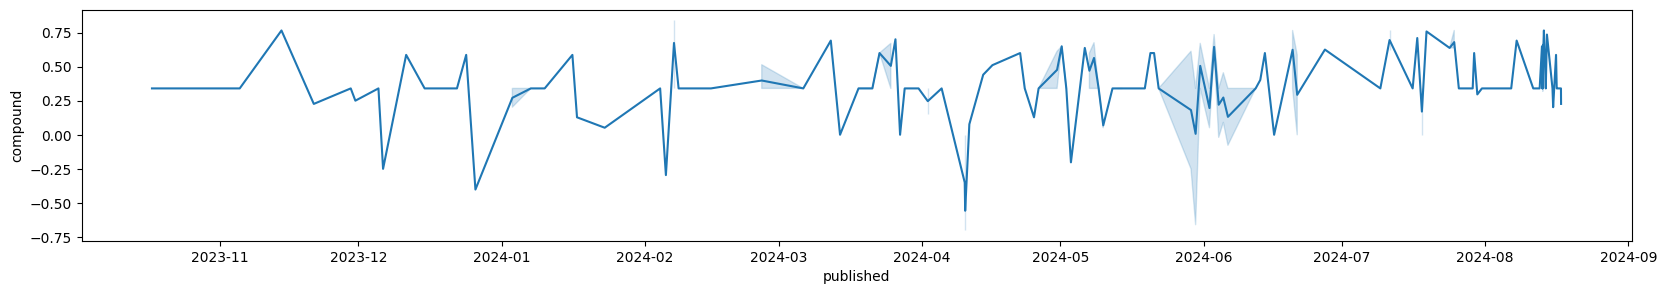

In [254]:
# Importing libraries
import seaborn as sns
import matplotlib.pyplot as plt

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 3))

# drawing the plot
sns.lineplot(df,x="published", y="compound")
plt.show()


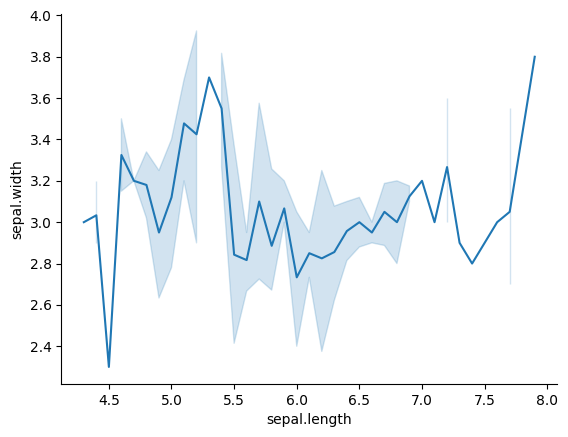

In [255]:
# loading dataset 
data = pd.read_csv("iris.csv") 

# draw lineplot 
sns.lineplot(x="sepal.length", y="sepal.width", data=data) 

# Removing the spines 
sns.despine() 
# current_palette = sns.color_palette() 
# sns.palplot(sns.color_palette("Greys")) 
plt.show()



In [256]:
sp500 = pd.read_csv("Data/S&P500-cleaned_returns.csv") 

In [257]:
sp500

,Date,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WRB,WST,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA
0,2006-01-04,0.002683,0.045670,0.002939,0.001516,0.005071,0.005446,-0.002599,0.009222,0.061252,...,0.023607,-0.021893,0.010332,0.023872,-0.001856,0.004834,0.001709,0.008520,0.009448,-0.009855
1,2006-01-05,0.025861,0.012926,-0.007900,0.012794,-0.014740,0.007440,-0.009152,0.031361,-0.024210,...,-0.003829,0.003551,-0.015263,-0.008830,-0.005960,-0.000536,-0.004964,0.041746,-0.010616,0.002826
2,2006-01-06,0.005208,-0.018041,0.025486,0.019011,0.018346,0.048341,0.024135,0.003917,0.029213,...,0.008645,-0.000787,-0.012158,0.001477,0.009482,0.003747,0.019540,-0.002852,-0.005130,0.036703
3,2006-01-09,-0.002891,-0.010050,-0.003283,0.036498,-0.009222,-0.002894,-0.016025,0.013976,0.012209,...,0.009561,0.008634,0.039787,-0.002365,0.046108,-0.002675,-0.000504,0.007722,0.034803,0.015072
4,2006-01-10,0.012941,-0.021202,0.061329,-0.009714,0.006338,-0.021807,0.005975,0.000000,-0.006467,...,0.005142,0.010109,-0.010204,0.013228,0.001236,0.004809,0.007713,-0.000810,-0.004267,0.036607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4678,2024-08-07,-0.017023,-0.005385,0.012421,0.004010,0.001654,-0.002073,-0.001129,-0.017578,0.003789,...,0.015845,-0.035743,0.003929,-0.015608,-0.019056,0.008604,0.013227,-0.003147,-0.034919,-0.006052
4679,2024-08-08,0.020686,0.065820,0.016496,-0.001639,0.016394,-0.006752,0.031846,0.059446,0.005143,...,0.012956,-0.002556,0.008964,-0.001606,0.023764,-0.003605,0.018924,0.004972,0.026947,0.022190
4680,2024-08-09,0.001023,-0.003038,0.013642,-0.009612,0.003956,-0.000158,0.011364,-0.010966,-0.000684,...,0.007379,-0.017801,-0.004725,-0.013597,-0.026707,-0.003273,0.008110,-0.002264,-0.005720,-0.005486
4681,2024-08-12,-0.009541,-0.025682,0.007105,-0.008406,-0.008335,-0.005938,-0.010064,0.003637,-0.006351,...,0.000525,0.009371,-0.002715,-0.017758,-0.009424,0.001035,0.001261,-0.008516,-0.010043,0.001218
